# Hypothesis testing

:::{warning} Under construction
This notebook comprises various text and code snippets for generating plots and other content for the lectures corresponding to this topic.  It is *not* a coherent set of lecture notes.  Students currently enrolled in the CCNY EAS 42000/A4200 course should refer to the lecture slides made available to them.
:::

## Online resources on hypothesis tests crowdsourced from Fall 2023 class

As part of [HW3](../assignments/hw-hypoth-tests), students reported on resources they found on YouTube and other sites to help them better understand hypothesis testing.  The list below is a compilation of those.

### Videos
- [*P-values and significance tests | AP Statistics | Khan Academy*](https://youtu.be/KS6KEWaoOOE?si=64bCJPRbgDf5Ee73) by [Khan Academy](https://www.youtube.com/@khanacademy)
- [*t-tests and p values*](https://youtu.be/2ARvj-8tJBs) by [Daniel M](https://www.youtube.com/@danielm9463) on YouTube.

### Blog posts, articles, etc.
- ["The Difference between T-Values and P-Values in Statistics"](https://www.statology.org/t-value-vs-p-value/).  Source: [https://www.statology.org](https://www.statology.org)


## The problem

Throughout this chapter on hypothesis testing, we'll use a concrete example from the Central Park weather station dataset: snowfall averaged over the first 20 years of the 20th century, 1900-1919, vs. the first 20 years of the 21st century, 2000-2019.  Perhaps we suspect that global warming has increased the amount of snow that falls in Central Park.  

(Or maybe we suspect the opposite; while mean warming tends to increase *precipitation* all else equal, for *frozen* precipitation like snow, you could imagine that warming causes more days to be above freezing, causing what would have been snow to be rain instead, thus actually decreasing snow fall.)

The first question we'll ask is: are these averages different?  Let's see:

In [1]:
from matplotlib import pyplot as plt
import numpy as np
import scipy
import xarray as xr

# Load daily averaged Central Park weather station data.
filepath_in = "../data/central-park-station-data_1869-01-01_2023-09-30.nc"
ds_cp_daily = xr.open_dataset(filepath_in)

In [2]:
# Compute annual averages.
ds_cp_ann = ds_cp_daily.groupby("time.year").mean()

In [3]:
# For snow, go from inches per day to total inches per year by multiplying
# by the number of days in each year
days_per_year = xr.DataArray(
    ds_cp_daily["temp_max"].groupby("time.year").count(dim="time").values,
    dims=["year"],
    coords={"year": ds_cp_ann["year"]},
    name="days_per_year",
)
snow_ann = ds_cp_ann["snow_fall"] * days_per_year

# Grab 1900-1919 and separately 2000-2019
snow_1900_19 = snow_ann.sel(year=slice(1900, 1919))
snow_2000_19 = snow_ann.sel(year=slice(2000, 2019))

# Compute total snow fall in each period
snow_mean_1900_19 = snow_1900_19.mean()
snow_mean_2000_19 = snow_2000_19.mean()

Text(0, 0.5, 'yearly snow fall [inches]')

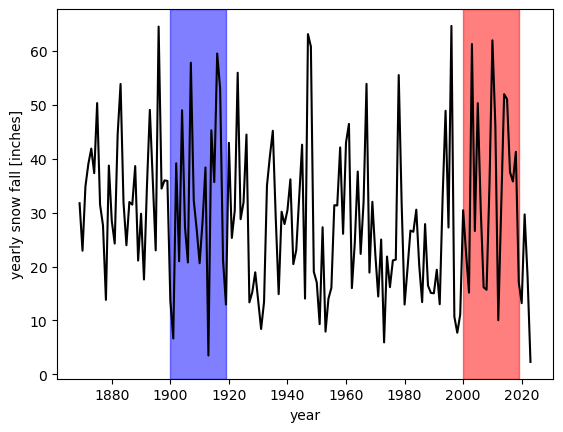

In [4]:
fig, ax = plt.subplots()
ax.axvspan(1900, 1919, color="blue", alpha=0.5)
ax.axvspan(2000, 2019, color="red", alpha=0.5)

snow_ann.plot(color="black")
ax.set_ylabel("yearly snow fall [inches]")

Text(0, 0.5, 'probability density [inches$^{-1}$]')

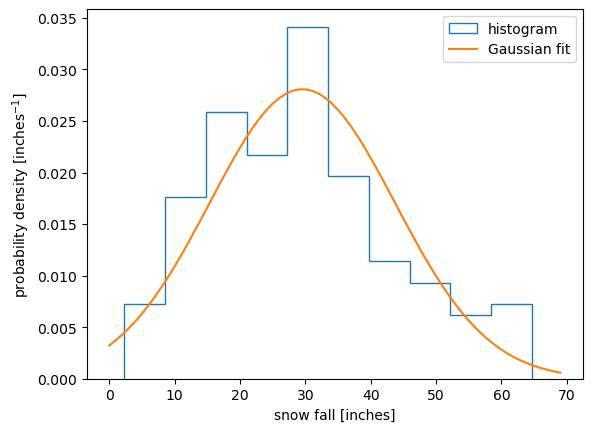

In [5]:
fig, ax = plt.subplots()
ax.hist(snow_ann, bins=10, density=True, histtype="step", label="histogram")

gauss_fit = scipy.stats.norm.fit(snow_ann)
gauss_fit_vals = scipy.stats.norm(*gauss_fit).pdf(np.arange(0, 70))
ax.plot(np.arange(0, 70), gauss_fit_vals, label="Gaussian fit")
ax.legend()
ax.set_xlabel("snow fall [inches]")
ax.set_ylabel(r"probability density [inches$^{-1}$]")

Text(0, 0.5, 'probability density [inches$^{-1}$]')

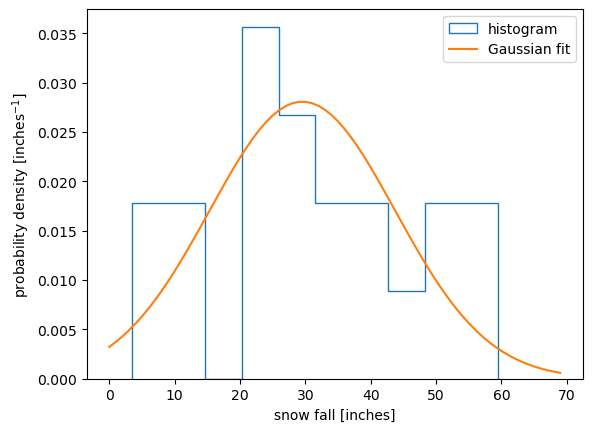

In [6]:
fig, ax = plt.subplots()
ax.hist(snow_1900_19, bins=10, density=True, histtype="step", label="histogram")

gauss_fit = scipy.stats.norm.fit(snow_ann)
gauss_fit_vals = scipy.stats.norm(*gauss_fit).pdf(np.arange(0, 70))
ax.plot(np.arange(0, 70), gauss_fit_vals, label="Gaussian fit")
ax.legend()
ax.set_xlabel("snow fall [inches]")
ax.set_ylabel(r"probability density [inches$^{-1}$]")

<xarray.DataArray ()> Size: 8B
array(30.65334808) <xarray.DataArray ()> Size: 8B
array(34.43115322) <xarray.DataArray ()> Size: 8B
array(3.77780514)


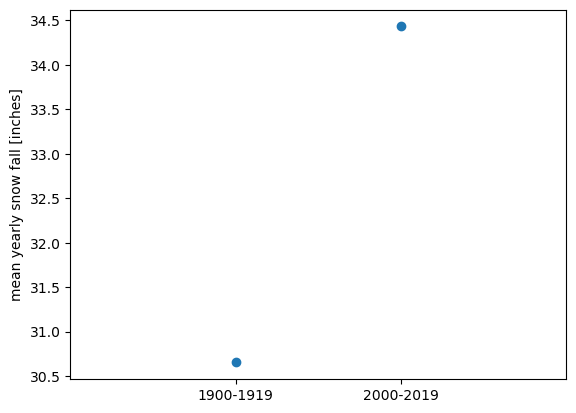

In [7]:
# Finally, plot them.
fig, ax = plt.subplots()
ax.scatter([0, 1], [snow_mean_1900_19, snow_mean_2000_19])
ax.set_xticks([0, 1])
ax.set_xticklabels(["1900-1919", "2000-2019"])
ax.set_xlim(-1, 2)
ax.set_ylabel("mean yearly snow fall [inches]")

print(snow_mean_1900_19, snow_mean_2000_19, snow_mean_2000_19 - snow_mean_1900_19)

In the earlier period the mean yearly snow accumulation was 30.6 inches, and for 2000-2019 it was higher, 34.4 inches.

Now the question we want to address is: how likely is it that this difference of 3.8" was *not* caused by random chance?

To answer that, we have to clarify: what would it mean for it to be "caused by random chance"?  This leads to the notion of *populations vs. samples*.

## Populations vs. samples

### Analogy to election polling

Put snow aside for a second, and think about public opinion polling.  For example, in the leadup to a U.S. presidential election, a candidate tries to track what percentage of the American **population** intends to vote for her.  (Of course, the total U.S. population is not identical to the population of registered voters, but having acknowledged that we can proceed.)

So they ask people by *polling* them, i.e. by having people fill out a survey asking who they intend to vote for.  Ideally, they'd do this for every member of the (voting) population.  But there are almost always far more voters than the candidate can plausibly ask.  To work around this, the pollsters try to select a *random subset* of the overall population.  This randomly drawn subset of the population is called the **sample**.

The hope is that, if the sample is (1) large enough and (2) really drawn randomly from the total population, then that sample is *representative* of the total population.  In that case, the results from the survey administered to this sample provide a reasonable estimate of how the whole population would vote.  (And moving forward, we'll go ahead and assume that the sample truly is drawn *randomly* from the population.)

In this case, there is one single population.  So if two different randomly drawn samples got different results---let's say in Sample 1 55.9% of respondents indicated they'd vote for Candidate X, but in Sample 2 only 54.3% indicated the same---then we can attribute that difference purely to random chance.

Now, the pollsters suspect that dog owners will be more likely to vote for their candidate, because the candidate's adorable Basset hound appears with her in all her campaign speeches and ads.  As such, they **hypothesize** that there are *two distinct populations* as regards voting patterns for this candidate: (1) the population of all dog owners, and (2) everybody else.  

However, there's no way of knowing this for sure; perhaps dog owners and non-dog owners admire the Basset hound equally, or don't find it relevant to how they should vote.  So the pollsters must **test** their hypothesis in some way.

They send out their surveys and get representative samples from each of these two populations, and find that in the sample of dog owners the percentage of "Yes" votes is 56.7%, and in the sample of non dog owners it's 55.9%.  So, yes, the two values are not identical; the dog owners answer yes by 0.8% more.

But the sample from each population will have the same issue with random noise as described above.  So the question becomes: how likely is it that the difference in the two sample values, 56.7% vs. 55.9%, is due to dog owners and non dog owners truly being different populations in how they view this candidate---as opposed to the two really being the same population, and the difference being due to random chance?

To answer this, we use **hypothesis tests**.

### Samples in the Central Park snow fall question

We have generated two **samples**: the values over 1900-1919 and the values over 2000-2019.

Each of these two samples has an identical **sample size**, i.e. the number of distinct values within the sample.  That sample size in this case is the number of years: we have a value for each of the 20 years in either period, so there are 20 distinct observations within either sample.  (Note: in general in hypothesis testing, the two sample sizes do not have to be identical.)

<xarray.DataArray ()> Size: 8B
array(30.65334808) <xarray.DataArray ()> Size: 8B
array(34.43115322) <xarray.DataArray ()> Size: 8B
array(3.77780514)


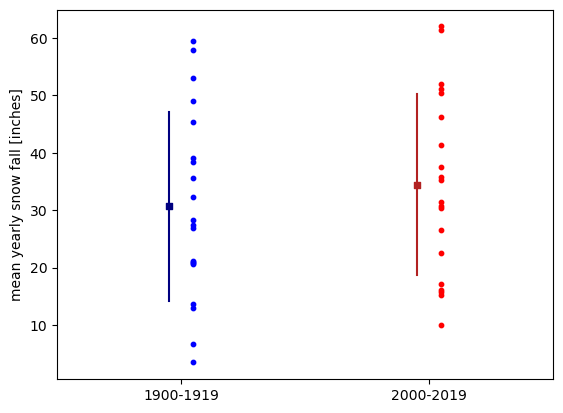

In [8]:
fig, ax = plt.subplots()

# Plot all 20 values for each sample.
ax.scatter([0.05] * 20, snow_1900_19.values, s=10, color="blue")
ax.scatter([1.05] * 20, snow_2000_19.values, s=10, color="red")

# Plot the sample mean and an error bar of plus or minus the sample standard deviation for each sample.
snow_std_1900 = snow_1900_19.std(ddof=1)
snow_std_2000 = snow_2000_19.std(ddof=1)

ax.scatter([-0.05], [snow_mean_1900_19], marker="s", s=20, color="navy")
ax.plot(
    [-0.05, -0.05],
    [snow_mean_1900_19 - snow_std_1900, snow_mean_1900_19 + snow_std_1900],
    color="navy",
)

ax.scatter([0.95], [snow_mean_2000_19], marker="s", s=20, color="firebrick")
ax.plot(
    [0.95, 0.95],
    [snow_mean_2000_19 - snow_std_2000, snow_mean_2000_19 + snow_std_2000],
    color="firebrick",
)

ax.set_xticks([0, 1])
ax.set_xticklabels(["1900-1919", "2000-2019"])
ax.set_xlim(-0.5, 1.5)
ax.set_ylabel("mean yearly snow fall [inches]")

print(snow_mean_1900_19, snow_mean_2000_19, snow_mean_2000_19 - snow_mean_1900_19)

(array([5., 2., 5., 2., 4., 2.]),
 array([10.03885714, 18.69689245, 27.35492775, 36.01296305, 44.67099836,
        53.32903366, 61.98706897]),
 [<matplotlib.patches.Polygon at 0x1643bce10>])

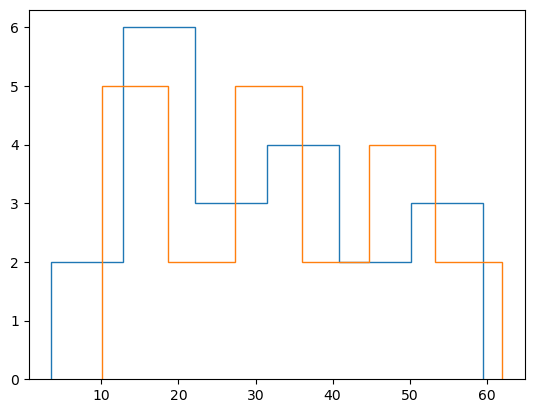

In [9]:
fig, ax = plt.subplots()
plt.hist(snow_1900_19, bins="auto", histtype="step")
plt.hist(snow_2000_19, bins="auto", histtype="step")

By eye, there's quite a lot of overlap between the two samples.

### Populations of Central Park snow fall

The identification above of the two **samples** of Central Park snow fall is hopefully intuitive.  Trickier is: what is/are the **population(s)** that these two samples are being randomly drawn from?  Are they the same population or different?  

It's impossible to infer this with certainty from any finite samples: for finite sample sizes, it is always *possible* that two samples were drawn from the same population, and that any differences between them were due to random chance.

And, taking one step back, how even is either population *distributed*?  Is it a normal distribution, a gamma distribution, or something else?  This too, we can never determine certaintly from finite samples (even assuming there was zero measurement error or any other confounding factors).  Instead, we *assume* that both samples are drawn from a particular distribution (for example, Gaussian), but that potentially the *parameters* of that population differ between the two.  With that assumed population distribution in hand, we ask: how likely is it that the two samples were drawn from .

For example, a normal distribution is defined by two parameters, its mean and standard deviation.  Two normal distributions are identical if and only if their means are identical *and* their standard deviations are identical.  In practice, often hypothesis testing skips over the question of whether their standard deviations are identical and jumps straight to asking whether the means are identical, *assuming that the standard deviations **are** indeed identical*.

In that case, hopefully it's intuitive that the best estimate of the population standard deviation is the average of the two sample standard deviations.  This is called the *pooled* estimate.

### Sample means and sample variances

In [10]:
import numpy as np

# Define population parameters
population_mean = 50
population_variance = 25  # sigma^2
population_size = 1000000
num_samples = 10000  # Number of samples
sample_size = 50  # Size of each sample

# Create a synthetic population
population = np.random.normal(
    population_mean, np.sqrt(population_variance), population_size
)

# Initialize lists to hold sample variances
variance_n = []
variance_n_minus_1 = []

# Generate samples and compute variances
for _ in range(num_samples):
    sample = np.random.choice(population, sample_size)
    variance_n.append(np.var(sample, ddof=0))
    variance_n_minus_1.append(np.var(sample, ddof=1))

# Compute the average of the sample variances
average_variance_n = np.mean(variance_n)
average_variance_n_minus_1 = np.mean(variance_n_minus_1)

print(f"Population variance: {population_variance}")
print(f"Average sample variance (N in denominator): {average_variance_n}")
print(f"Average sample variance (N-1 in denominator): {average_variance_n_minus_1}")

Population variance: 25
Average sample variance (N in denominator): 24.51474340986275
Average sample variance (N-1 in denominator): 25.015044295778317


An {term}`unbiased measure` of the {term}`sample variance`, denoted $s^2$, of a sample $x_1,\dots,x_N$ containing $N$ data points is given by   
$$s^2=\frac{1}{N-1}\sum_{i=1}^{N}\left(x_i-\overline{x}\right)^2$$

## The null hypothesis and the alternative hypothesis

The **null hypothesis** is that the two populations are the *same*.  In our example, this would mean that the 1900-1919 yearly snow fall and 2000-2019 yearly snow fall are both being drawn from the same distribution.  The standard notation for the null hypothesis is $H_0$.

The **alternative hypothesis** is, well, some other hypothesis than the null.  Most often, it is simply that the null hypothesis is not true (i.e. it is the *complement* of the null hypothesis).  Its standard notation is $H_A$.

Let's denote our 1900-1919 and 2000-2019 snowfall populations as $p_{20th}$ and $p_{21st}$, respectively (the subscripts allude to the 20th century vs. the 21st century).  Then our null hypothesis is $H_O$: $p_{20th}=p_{21st}$, and our alternative hypothesis is $H_A$: $p_{20th}\neq p_{21st}$.

## Decision rules and p values

What value of the test statistic is sufficient to reject the null hypothesis?  There is no single right answer.

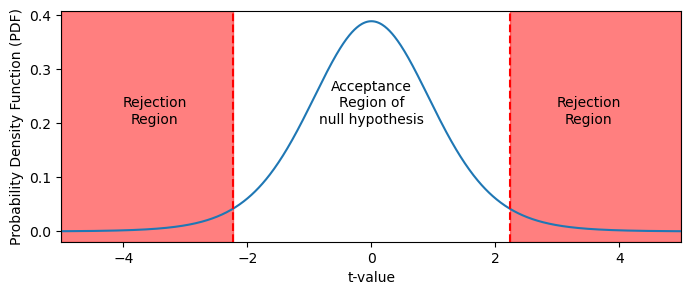

In [11]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import t

# Parameters
df = 10  # Degrees of freedom
alpha = 0.05  # Significance level

# Calculate critical t-value (two-tailed)
t_crit = t.ppf(1 - alpha / 2, df)

# Values for plotting
x = np.linspace(-5, 5, 1000)
y = t.pdf(x, df)

# Create the plot
fig, ax = plt.subplots(figsize=(8, 3))

# Plot t-distribution
ax.plot(x, y)

# Add rejection regions
ax.axvspan(-5, -t_crit, color="red", alpha=0.5)
ax.axvspan(t_crit, 5, color="red", alpha=0.5)

# Add critical t-values
ax.axvline(-t_crit, color="red", linestyle="--")
ax.axvline(t_crit, color="red", linestyle="--")

# Label regions
ax.text(-3.5, 0.2, "Rejection\nRegion", color="black", ha="center")
ax.text(3.5, 0.2, "Rejection\nRegion", color="black", ha="center")
ax.text(0, 0.2, "Acceptance\nRegion of\nnull hypothesis", color="black", ha="center")

ax.set_xlim(-5, 5)
plt.xlabel("t-value")
plt.ylabel("Probability Density Function (PDF)")
plt.show()

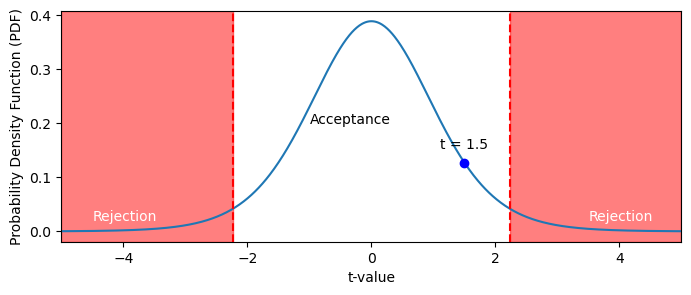

In [12]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import t

# Parameters
df = 10  # Degrees of freedom
alpha = 0.05  # Significance level
t_value = 1.5  # Observed t-statistic value

# Calculate critical t-values
t_crit = t.ppf(1 - alpha / 2, df)

# Values for plotting
x = np.linspace(-5, 5, 1000)
y = t.pdf(x, df)

# Create the plot
fig, ax = plt.subplots(figsize=(8, 3))

# Plot t-distribution
ax.plot(x, y)

# Add rejection regions
ax.axvspan(-5, -t_crit, color="red", alpha=0.5)
ax.axvspan(t_crit, 5, color="red", alpha=0.5)

# Add critical t-values
ax.axvline(-t_crit, color="red", linestyle="--")
ax.axvline(t_crit, color="red", linestyle="--")

# Label regions
ax.text(-4.5, 0.02, "Rejection", color="white")
ax.text(3.5, 0.02, "Rejection", color="white")
ax.text(-1, 0.2, "Acceptance", color="black")

ax.set_xlim(-5, 5)
# Overlay observed t-statistic value
ax.plot(t_value, t.pdf(t_value, df), "bo")  # Add a blue dot for the t-value
ax.annotate(
    f"t = {t_value}",
    (t_value, t.pdf(t_value, df)),
    textcoords="offset points",
    xytext=(0, 10),
    ha="center",
)

plt.xlabel("t-value")
plt.ylabel("Probability Density Function (PDF)")
plt.show()

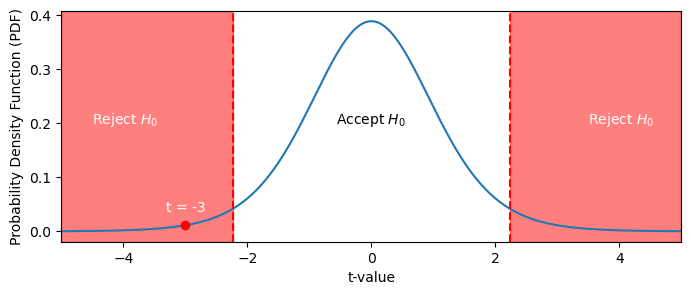

In [13]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import t

# Parameters
df = 10  # Degrees of freedom
alpha = 0.05  # Significance level
t_value = -3  # Observed t-statistic value

# Calculate critical t-values
t_crit = t.ppf(1 - alpha / 2, df)

# Values for plotting
x = np.linspace(-5, 5, 1000)
y = t.pdf(x, df)

# Create the plot
fig, ax = plt.subplots(figsize=(8, 3))

# Plot t-distribution
ax.plot(x, y)

# Add rejection regions
ax.axvspan(-5, -t_crit, color="red", alpha=0.5)
ax.axvspan(t_crit, 5, color="red", alpha=0.5)

# Add critical t-values
ax.axvline(-t_crit, color="red", linestyle="--")
ax.axvline(t_crit, color="red", linestyle="--")

# Label regions
ax.text(-4.5, 0.2, r"Reject $H_0$", color="white")
ax.text(3.5, 0.2, r"Reject $H_0$", color="white")
ax.text(0, 0.2, r"Accept $H_0$", color="black", ha="center")

ax.set_xlim(-5, 5)
# Overlay observed t-statistic value
ax.plot(t_value, t.pdf(t_value, df), "ro")  # Add a blue dot for the t-value
ax.annotate(
    f"t = {t_value}",
    (t_value, t.pdf(t_value, df)),
    textcoords="offset points",
    xytext=(0, 10),
    ha="center",
    color="white",
)

plt.xlabel("t-value")
plt.ylabel("Probability Density Function (PDF)")
plt.show()

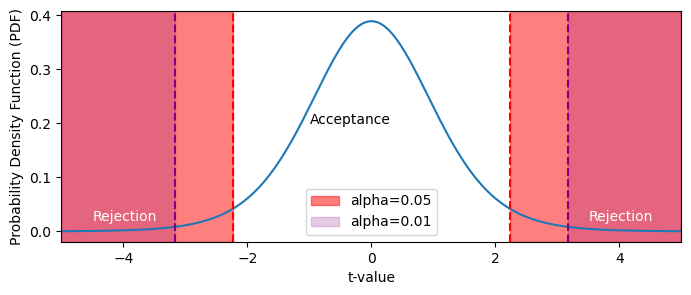

In [14]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import t

# Parameters
df = 10  # Degrees of freedom
alpha1 = 0.05  # Significance level
alpha2 = 0.01  # More stringent significance level

# Calculate critical t-values
t_crit1 = t.ppf(1 - alpha1 / 2, df)
t_crit2 = t.ppf(1 - alpha2 / 2, df)

# Values for plotting
x = np.linspace(-5, 5, 1000)
y = t.pdf(x, df)

# Create the plot
fig, ax = plt.subplots(figsize=(8, 3))

# Plot t-distribution
ax.plot(x, y)

# Add rejection regions for alpha1
ax.axvspan(-5, -t_crit1, color="red", alpha=0.5, label=f"alpha={alpha1}")
ax.axvspan(t_crit1, 5, color="red", alpha=0.5)

# Add rejection regions for alpha2
ax.axvspan(-5, -t_crit2, color="purple", alpha=0.2, label=f"alpha={alpha2}")
ax.axvspan(t_crit2, 5, color="purple", alpha=0.2)

# Add critical t-values
ax.axvline(-t_crit1, color="red", linestyle="--")
ax.axvline(t_crit1, color="red", linestyle="--")
ax.axvline(-t_crit2, color="purple", linestyle="--")
ax.axvline(t_crit2, color="purple", linestyle="--")

# Label regions
ax.text(-4.5, 0.02, "Rejection", color="white")
ax.text(3.5, 0.02, "Rejection", color="white")
ax.text(-1, 0.2, "Acceptance", color="black")

ax.set_xlim(-5, 5)

plt.xlabel("t-value")
plt.ylabel("Probability Density Function (PDF)")
plt.legend()
plt.show()

## Performing the test

### The upshot

The key quantity is $T_0$:

$$T_0=\frac{\hat\mu_{21st}-\hat\mu_{20th}}{\hat\sigma_p\sqrt{\frac{1}{N_{21st}}+\frac{1}{N_{20th}}}},$$

where $\hat\sigma_p$ is the square root of the *pooled variance* $\hat\sigma_p^2$:

$$\hat\sigma_p^2=\frac{(N_{21st}-1)\hat\sigma_{21st}^2+(N_{20th}-1)\hat\sigma_{20th}^2}{N_{21st}+N_{20th}-2}.$$

This amounts to an average of the two sample variances weighted by the sample size in each.  In the case where the two sample sizes are identical, this becomes the simple, unweighted average of the two: $\hat\sigma_p^2=(\hat\sigma_{20th}^2+\hat\sigma_{21st}^2)/2$, and the whole denominator of the quantity $T_0$ becomes $(\hat\sigma_{20th}^2+\hat\sigma_{21st}^2)/\sqrt{N}$, where $N$ is the sample size.

Now let's plug in our values and see what we get:

In [15]:
mean_diff = snow_mean_2000_19 - snow_mean_1900_19

snow_var_1900 = snow_1900_19.var(ddof=1)
snow_var_2000 = snow_2000_19.var(ddof=1)
pooled_var = 0.5 * (snow_var_1900 + snow_var_2000)

num_1900 = len(snow_1900_19)
num_2000 = len(snow_2000_19)

t_snow_1900_v_2000 = mean_diff / np.sqrt(2 * pooled_var / num_1900)

print(t_snow_1900_v_2000.values)

0.742899657933769


In [16]:
def t_stat(sam_mean1, sam_mean2, sam_var1, sam_var2, num_obs):
    """t statistic assuming equal number of obs in the two samples."""
    numer = sam_mean1 - sam_mean2
    denom = np.sqrt((sam_var1 + sam_var2) / num_obs)
    return numer / denom


t_1900_v_2000 = t_stat(
    snow_mean_2000_19, snow_mean_1900_19, snow_var_1900, snow_var_2000, num_1900
)
t_1900_v_2000

<xarray.DataArray ()> Size: 8B
array(0.74289966)

Now we'll determine the corresponding $p$ value: 

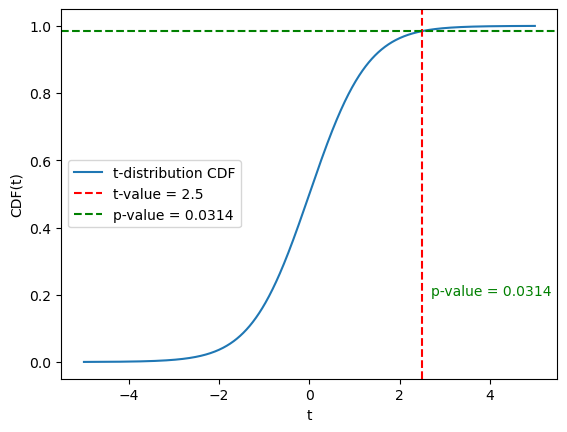

In [17]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import t

# Parameters
df = 10  # Degrees of freedom
t_value = 2.5  # Specific t-value for illustration

# Generate data
x = np.linspace(-5, 5, 1000)
y_cdf = t.cdf(x, df)

# Compute p-value at given t-value
p_value = 2 * (1 - t.cdf(np.abs(t_value), df))

# Plotting
fig, ax = plt.subplots()
ax.plot(x, y_cdf, label="t-distribution CDF")
ax.axvline(t_value, color="r", linestyle="--", label=f"t-value = {t_value}")
ax.axhline(1 - p_value / 2, color="g", linestyle="--", label=f"p-value = {p_value:.4f}")

# Annotations
ax.text(t_value + 0.2, 0.2, f"p-value = {p_value:.4f}", color="g")

# Labels and Title
ax.set_xlabel("t")
ax.set_ylabel("CDF(t)")
ax.legend()
plt.show()

In [18]:
2 * (1 - scipy.stats.t.cdf((t_1900_v_2000), 38))

np.float64(0.4621106533064214)

So our p value is 0.46.  This is far above any standard critical value used for decision rules (like 0.01, 0.05, or the most lenient, 0.10).

In other words, we do not reject the null hypothesis: it is entirely plausible that the snow fall in the two time periods is not being drawn from distinct populations.

Finally, we can verify this calculation we've performed by hand against scipy's [ttest_ind]() function:

In [19]:
np.isclose(0.74289966, 0.7428996579337688)

np.True_

In [20]:
scipy.stats.ttest_ind(snow_1900_19, snow_2000_19)

TtestResult(statistic=np.float64(-0.7428996579337688), pvalue=np.float64(0.46211065330642187), df=np.float64(38.0))

### [incomplete] The more detailed derivation of the $t$ statistic

In class, we skipped over most of the derivation leading to the precise value of the $t$ statistic for difference in means.  Here we'll walk through the steps of that derivation to make sure we understand it.

1. We collect two samples of observations, call one $S_1$ and the other $S_2$.  The respective *sample* means are $\hat\mu_1$ and $\hat\mu_2$.
2. We *assume* that the values in each sample were drawn *randomly* from a specific probability *distribution* (i.e. the population).  Call these distributions $p_1$ and $p_2$.
3. We want to know whether two samples are drawn from the same distribution or a different one: does $p_1=p_2$?  Or $p_1\neq p_2$?  The first case is the *null hypothesis*: $H_0^*$: $p_1=p_2$.  The second is the *alternative hypothesis*: $H_A^*$: $p_1\neq p_2$.
4. We'll assume that both distributions are normal: $p_1=\mathcal{N}(\mu_1,\sigma_1^2)$ and $p_2\sim\mathcal{N}(\mu_2,\sigma_2^2)$, where $\mathcal{N}(\mu,\sigma^2)$ denotes a normal distribution with mean $\mu$ and variance $\sigma^2$.
5. In that case, if the two distributions are the same, then the means are equal and the variances are equal: $\mu_1=\mu_2$ and $\sigma_1^2=\sigma_2^2$.
6. To test for a difference in the means, we'll *assume* that the variances (and hence standard deviations) are equal: $\sigma_1^2=\sigma_2^2$, or equivalently $\sigma_1=\sigma_2$.
7. We then assume that, indeed, the population means are identical: $\mu_1=\mu_2$.  This results in a refined *null hypothesis* $H_0$: $\mu_1=\mu_2$ and $\sigma_1=\sigma_2$.  The corresponding refined *alternative hypothesis* is: $H_A$: $\mu_1\neq\mu_2$ and $\sigma_1=\sigma_2$.
8. Whereas the two sample means are (almost always) not: $\hat\mu_1-\hat\mu_2\neq0$.  (If they're truly identical, $\hat\mu_1=\hat\mu_2$, then no statistical test will reject $H_0$, so your job is done.)
9. We then ask: what's the probability of drawing two samples randomly from this distribution (i.e. from $\mathcal{N}(\mu_1,\sigma_1^2)=\mathcal{N}(\mu_2,\sigma_2^2)$) with a difference in their means *at least as large* in magnitude as the observed difference between the two *sample* means, $\hat\mu_1-\hat\mu_2$.
10. But we don't know $\mu_1$, $\mu_2$, $\sigma_1$, or $\sigma_2$!  So how to proceed?
11. We consider the *sampling distribution*: the distribution of $\hat\mu_1-\hat\mu_2$ that would arise in the case that $H_0$ is true.

### Step 1: distributions of $\hat\mu_1$ and $\hat\mu_2$

Use a random number gnerator to convince yourself of the following: 
$$\hat\mu_1\sim N\left(\mu_1,\frac{\sigma^2_1}{N_1}\right),\quad\quad\hat\mu_2\sim N\left(\mu_2,\frac{\sigma^2_2}{N_2}\right)$$
In words: the sample means are normally distributed, with mean equal to their population's mean and the variance equal to the population variance divided by the sample size.

These both follow from the following general rule (a.k.a. *theorem*): Consider values $X_1$, $X_2$, $\dots$, $X_{N_X}$ drawn randomly and independently from a normal distribution $\mathcal{N}(\mu_X, \sigma^2_X)$.  If $\hat\mu_X$ is the sample mean of these $N$ values, then the *distribution* of $\hat\mu_X$ is also normal.  Specifically, $\hat\mu_X\sim\mathcal{N}\left(\hat\mu,  \frac{\sigma^2_X}{N_X}\right)$.

There are two components to this: (1) that $E[\hat\mu_X]=\mu_X$, i.e. that the expectation of the sample mean is the population mean, and (2) that $\text{var}[\hat\mu_X]=\sigma^2_X/N_X$, i.e. that the variance of the sample mean with sample size $N_X$ is the population variance divided by the sample size.

The corresponding standard deviation, $\sigma_X/\sqrt{N_X}$, is called the **standard error** of the mean.

Notice that the variance of the sample mean *decreases* as the sample size *increases*.  This implies that, as the sample size gets larger and larger, it converges to the true population mean: $\hat\mu_X\rightarrow\mu_X$ as $N_X\rightarrow\infty$.

We have computed the sample mean and sample variance for both of our samples: $\hat\mu_{20th}$ and $\hat\sigma_{20th}^2$ for 1900-1919 and $\hat\mu_{21st}$ and $\hat\sigma_{21st}^2$ for 2000-2019.

We know that the sample means are both normally distributed:
$\hat\mu_{20th}\sim\cal{N}\left(\mu_{20th},\frac{\sigma_{20th}^2}{N_{20th}}\right)$ and
$\hat\mu_{21st}\sim\cal{N}\left(\mu_{21st},\frac{\sigma_{21st}^2}{N_{21st}}\right)$.

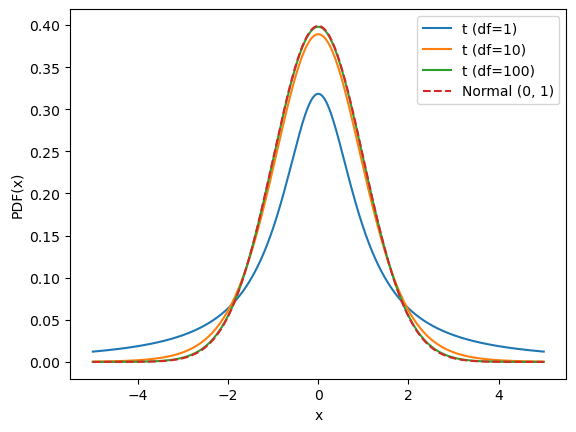

In [21]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import t, norm

# Generate data
x = np.linspace(-5, 5, 1000)

# PDF of t-distributions
y_t1 = t.pdf(x, 1)
y_t10 = t.pdf(x, 10)
y_t100 = t.pdf(x, 100)

# PDF of standard normal distribution
y_norm = norm.pdf(x, 0, 1)

# Plotting
fig, ax = plt.subplots()
ax.plot(x, y_t1, label="t (df=1)")
ax.plot(x, y_t10, label="t (df=10)")
ax.plot(x, y_t100, label="t (df=100)")
ax.plot(x, y_norm, label="Normal (0, 1)", linestyle="--")

# Labels and Title
ax.set_xlabel("x")
ax.set_ylabel("PDF(x)")
ax.legend()
plt.show()

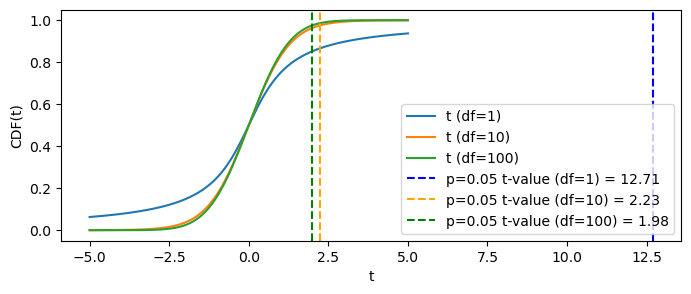

In [22]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import t

# Generate data
x = np.linspace(-5, 5, 1000)

# CDF of t-distributions
cdf_t1 = t.cdf(x, 1)
cdf_t10 = t.cdf(x, 10)
cdf_t100 = t.cdf(x, 100)

# Calculate t-values for p=0.05
t_val1 = t.ppf(1 - 0.025, 1)
t_val10 = t.ppf(1 - 0.025, 10)
t_val100 = t.ppf(1 - 0.025, 100)

# Plotting
fig, ax = plt.subplots(figsize=(8, 3))
ax.plot(x, cdf_t1, label="t (df=1)")
ax.plot(x, cdf_t10, label="t (df=10)")
ax.plot(x, cdf_t100, label="t (df=100)")

# Mark t-values
ax.axvline(
    x=t_val1,
    linestyle="--",
    color="blue",
    label=f"p=0.05 t-value (df=1) = {t_val1:.2f}",
)
ax.axvline(
    x=t_val10,
    linestyle="--",
    color="orange",
    label=f"p=0.05 t-value (df=10) = {t_val10:.2f}",
)
ax.axvline(
    x=t_val100,
    linestyle="--",
    color="green",
    label=f"p=0.05 t-value (df=100) = {t_val100:.2f}",
)

# Labels and Title
ax.set_xlabel("t")
ax.set_ylabel("CDF(t)")
ax.legend()

plt.show()

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
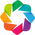

Column
    [0] IntSlider(end=50, name='Degrees of Freedom', start=1, value=1)
    [1] Row
        [0] HoloViews(DynamicMap, height=400, sizing_mode='fixed', width=600)
        [1] WidgetBox(align=('end', 'start'))
            [0] DiscreteSlider(formatter='%d', name='df', options={'1': np.int64(1), ...}, value=np.int64(1))

In [23]:
import holoviews as hv
from holoviews import opts
from scipy.stats import t, norm
import numpy as np
import panel as pn

hv.extension("bokeh")


def plot_t_distribution(df=1):
    x = np.linspace(-5, 5, 400)
    y_t = t.pdf(x, df)
    y_norm = norm.pdf(x, 0, 1)

    curve_t = (
        hv.Curve((x, y_t), "x", "Density")
        .opts(line_color="purple")
        .relabel("t-distribution")
    )
    curve_norm = (
        hv.Curve((x, y_norm), "x", "Density")
        .opts(line_color="green")
        .relabel("Standard Normal")
    )
    return (curve_t * curve_norm).opts(
        legend_position="top_right", width=600, height=400
    )


df_slider = pn.widgets.IntSlider(
    name="Degrees of Freedom", start=1, end=50, step=1, value=1
)
dmap = hv.DynamicMap(plot_t_distribution, kdims=["df"])

pn.Column(df_slider, dmap.redim.values(df=list(range(1, 51)))).servable()

## (temperature)

In [24]:
tmin_ann = ds_cp_ann["temp_min"]

# Grab 1900-1919 and separately 2000-2019
tmin_1900_19 = tmin_ann.sel(year=slice(1900, 1919))
tmin_2000_19 = tmin_ann.sel(year=slice(2000, 2019))

# Compute sample mean and sample standard deviation for each period
tmin_mean_1900_19 = tmin_1900_19.mean()
tmin_mean_2000_19 = tmin_2000_19.mean()
tmin_std_1900_19 = tmin_1900_19.std(ddof=1)
tmin_std_2000_19 = tmin_2000_19.std(ddof=1)

<xarray.DataArray 'temp_min' ()> Size: 8B
array(46.35545849) <xarray.DataArray 'temp_min' ()> Size: 8B
array(48.6393772) <xarray.DataArray 'temp_min' ()> Size: 8B
array(2.28391871)


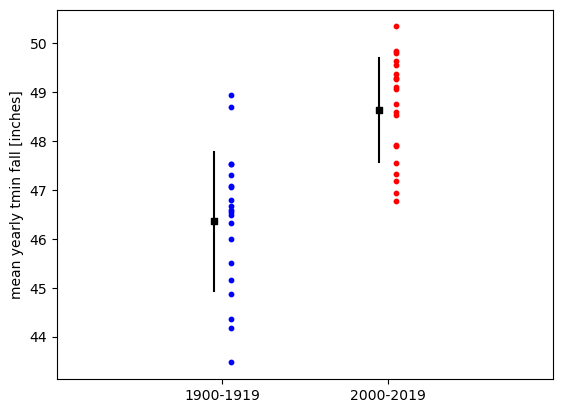

In [25]:
fig, ax = plt.subplots()

# Plot all 20 values for each sample.
ax.scatter([0.05] * 20, tmin_1900_19.values, s=10, color="blue")
ax.scatter([1.05] * 20, tmin_2000_19.values, s=10, color="red")

# Plot the sample mean and an error bar of plus or minus the sample standard deviation for each sample.
ax.scatter(
    [-0.05, 0.95],
    [tmin_mean_1900_19, tmin_mean_2000_19],
    marker="s",
    s=20,
    color="black",
)
ax.plot(
    [-0.05, -0.05],
    [tmin_mean_1900_19 - tmin_std_1900_19, tmin_mean_1900_19 + tmin_std_1900_19],
    color="black",
)
ax.plot(
    [0.95, 0.95],
    [tmin_mean_2000_19 - tmin_std_2000_19, tmin_mean_2000_19 + tmin_std_2000_19],
    color="black",
)

ax.set_xticks([0, 1])
ax.set_xticklabels(["1900-1919", "2000-2019"])
ax.set_xlim(-1, 2)
ax.set_ylabel("mean yearly tmin fall [inches]")

print(tmin_mean_1900_19, tmin_mean_2000_19, tmin_mean_2000_19 - tmin_mean_1900_19)

(array([0.00450036, 0.        , 0.00900072, 0.06750539, 0.13951115,
        0.26552122, 0.11700935, 0.09000719, 0.        , 0.00450036]),
 array([38.88767123, 40.32124843, 41.75482563, 43.18840283, 44.62198003,
        46.05555723, 47.48913443, 48.92271163, 50.35628883, 51.78986602,
        53.22344322]),
 [<matplotlib.patches.Polygon at 0x167a947d0>])

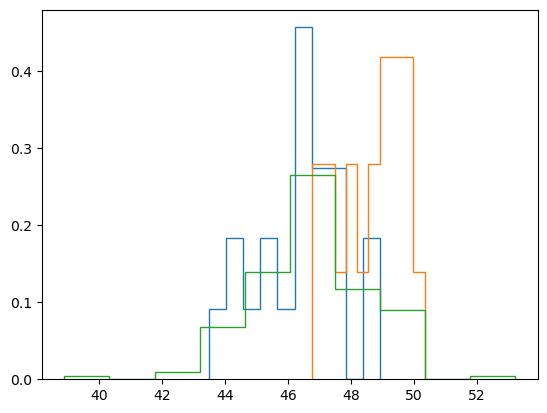

In [26]:
fig, ax = plt.subplots()
plt.hist(tmin_1900_19, histtype="step", density=True)
plt.hist(tmin_2000_19, histtype="step", density=True)
plt.hist(tmin_ann, histtype="step", density=True)

Text(0, 0.5, 'yearly snow fall [inches]')

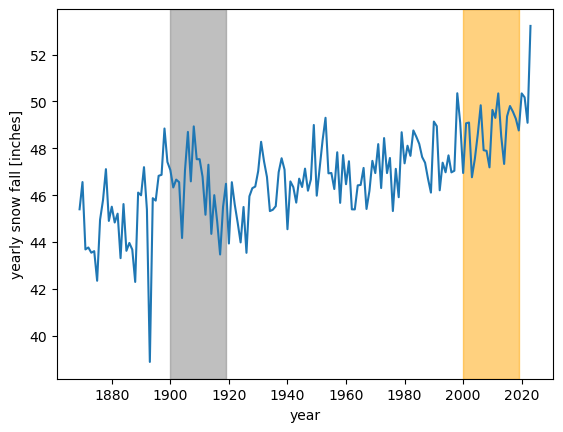

In [27]:
fig, ax = plt.subplots()
ax.axvspan(1900, 1919, color="grey", alpha=0.5)
ax.axvspan(2000, 2019, color="orange", alpha=0.5)

tmin_ann.plot()
ax.set_ylabel("yearly snow fall [inches]")

In [28]:
mean_diff_tmin = tmin_mean_2000_19 - tmin_mean_1900_19

tmin_var_1900 = tmin_1900_19.var(ddof=1)
tmin_var_2000 = tmin_2000_19.var(ddof=1)
pooled_var = 0.5 * (tmin_var_1900 + tmin_var_2000)

num_1900 = len(tmin_1900_19)
num_2000 = len(tmin_2000_19)

t_1900_v_2000 = mean_diff / np.sqrt(2.0 * pooled_var / num_1900)
t_1900_v_2000

<xarray.DataArray ()> Size: 8B
array(9.46171866)

Text(0, 0.5, 'probability density [$^\\circ$F$^{-1}$]')

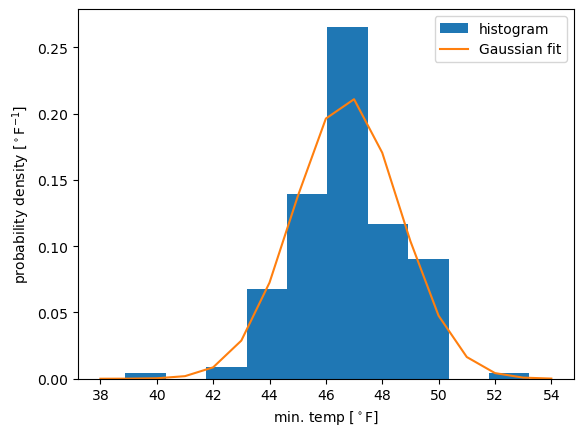

In [29]:
fig, ax = plt.subplots()
ax.hist(tmin_ann, bins=10, density=True, label="histogram")

gauss_fit_tmin = scipy.stats.norm.fit(tmin_ann)
gauss_fit_tmin_vals = scipy.stats.norm(*gauss_fit_tmin).pdf(np.arange(38, 55))
ax.plot(np.arange(38, 55), gauss_fit_tmin_vals, label="Gaussian fit")
ax.legend()
ax.set_xlabel(r"min. temp [$^\circ$F]")
ax.set_ylabel(r"probability density [$^\circ$F$^{-1}$]")

In [30]:
scipy.stats.ttest_ind(tmin_1900_19, tmin_2000_19)

TtestResult(statistic=np.float64(-5.720198743021243), pvalue=np.float64(1.3779053112043898e-06), df=np.float64(38.0))